In [ ]:

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn import linear_model
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
# from keras.utils.vis_utils import plot_model
from keras.utils import plot_model
import sklearn.metrics as metrics
import random

In [ ]:

df=pd.read_csv("27.csv",na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)

close_price_mid = []
close_price_25th = []
close_price_75th = []
for values in df['Close Price']:
  margin1 = round(random.uniform(-2,2),2)
  temp1 = values + ((margin1*values)/100)
  temp1 = round(temp1,2)
  close_price_mid.append(temp1)
  margin2 = round(random.uniform(-2,2),2)
  temp2 = values + ((margin2*values)/100)
  temp2 = round(temp2,2)
  close_price_25th.append(temp2)
  margin3 = round(random.uniform(-2,2),2)
  temp3 = values + ((margin3*values)/100)
  temp3 = round(temp3,2)
  close_price_75th.append(temp3)
df = df.assign(one_fourth_close_price = close_price_25th)
df = df.assign(mid_close_price = close_price_mid)
df = df.assign(three_fourth_close_price = close_price_75th)


In [ ]:
df.head(100)

,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open,one_fourth_close_price,mid_close_price,three_fourth_close_price
Date,,,,,,,,,,,,,,,
2023-09-07,448.35,448.75,444.65,445.75,446.067056,343327,12096,153146864.0,165870.0,48.31,4.10,-2.60,454.31,453.10,445.53
2023-09-06,443.10,448.45,441.90,447.50,445.375963,248237,8808,110558793.0,89253.0,35.95,6.55,4.40,453.14,445.71,450.72
2023-09-05,438.05,444.05,438.05,443.05,440.979954,633508,18651,279364329.0,431227.0,68.07,6.00,5.00,442.92,451.78,436.18
2023-09-04,441.35,442.95,436.65,437.55,438.766239,721463,29157,316553607.0,443287.0,61.44,6.30,-3.80,444.59,441.36,433.57
2023-09-01,439.65,445.05,438.10,441.25,441.575303,775553,18732,342465051.0,112487.0,14.50,6.95,1.60,437.41,435.73,443.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24,410.00,410.00,404.20,408.60,406.531899,388848,10525,158079116.0,183020.0,47.07,5.80,-1.40,406.27,409.95,408.31
2023-04-21,398.60,409.00,398.60,408.25,405.422232,640946,14229,259853758.0,330863.0,51.62,10.40,9.65,413.76,411.68,409.84
2023-04-20,399.05,402.60,397.95,400.30,400.100839,138815,4726,55539998.0,50755.0,36.56,4.65,1.25,392.29,401.90,403.22


In [ ]:

print("Dataframe Shape:" , df. shape)
print("Null Value Present: ", df.isnull().values.any())

Dataframe Shape: (2646, 15)
Null Value Present:  True


<Axes: xlabel='Date'>

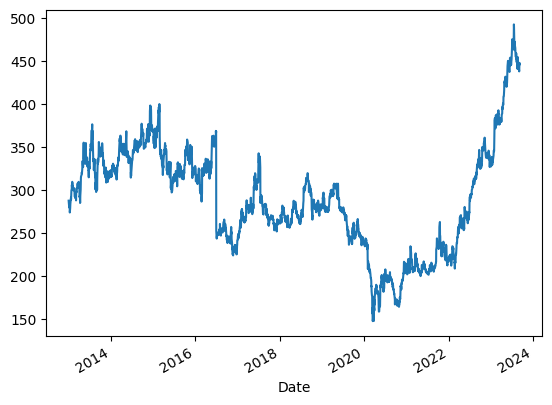

In [ ]:

df['Close Price'].plot()


In [ ]:
#Set Target Variable
output_var = pd.DataFrame(df['Close Price'])
#Selecting the Features
features = ['Open Price', 'High Price', 'Low Price', 'No.of Shares','one_fourth_close_price','mid_close_price','three_fourth_close_price']
print(output_var)

            Close Price
Date                   
2023-09-07       445.75
2023-09-06       447.50
2023-09-05       443.05
2023-09-04       437.55
2023-09-01       441.25
...                 ...
2013-01-07       279.20
2013-01-04       282.40
2013-01-03       283.50
2013-01-02       285.50
2013-01-01       287.25

[2646 rows x 1 columns]


In [ ]:
#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open Price,High Price,Low Price,No.of Shares,one_fourth_close_price,mid_close_price,three_fourth_close_price
Date,,,,,,,
2023-09-07,0.872590,0.853753,0.879580,0.022535,0.871158,0.911043,0.854502
2023-09-06,0.857371,0.852890,0.871769,0.015955,0.867832,0.889123,0.869329
2023-09-05,0.842731,0.840236,0.860835,0.042617,0.838778,0.907128,0.827791
2023-09-04,0.852297,0.837072,0.856859,0.048704,0.843525,0.876220,0.820335
2023-09-01,0.847369,0.843112,0.860977,0.052447,0.823113,0.859520,0.848075


In [ ]:

timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()
print(X_train)
print(X_test)
print(y_train)
print(y_test)

            Open Price  High Price  Low Price  No.of Shares  \
Date                                                          
2023-09-07    0.872590    0.853753   0.879580      0.022535   
2023-09-06    0.857371    0.852890   0.871769      0.015955   
2023-09-05    0.842731    0.840236   0.860835      0.042617   
2023-09-04    0.852297    0.837072   0.856859      0.048704   
2023-09-01    0.847369    0.843112   0.860977      0.052447   
...                ...         ...        ...           ...   
2013-12-23    0.488766    0.482169   0.511360      0.021735   
2013-12-20    0.491810    0.474835   0.498438      0.031537   
2013-12-19    0.489636    0.474691   0.500284      0.062196   
2013-12-18    0.488911    0.475122   0.505680      0.017940   
2013-12-17    0.483113    0.471527   0.503976      0.016609   

            one_fourth_close_price  mid_close_price  three_fourth_close_price  
Date                                                                           
2023-09-07          

In [ ]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])


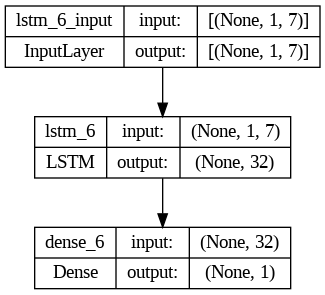

In [ ]:
#Building the LSTM Model
lstm = Sequential()

lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

In [ ]:
history=lstm.fit(X_train, y_train, epochs=300, batch_size=8, verbose=1, shuffle=False)

Epoch 1/300
301/301 [==============================] - 3s 3ms/step - loss: 84037.0625
Epoch 2/300
301/301 [==============================] - 1s 2ms/step - loss: 72354.1875
Epoch 3/300
301/301 [==============================] - 1s 2ms/step - loss: 53673.6367
Epoch 4/300
301/301 [==============================] - 1s 2ms/step - loss: 34427.5859
Epoch 5/300
301/301 [==============================] - 1s 2ms/step - loss: 18687.0781
Epoch 6/300
301/301 [==============================] - 1s 2ms/step - loss: 8336.8477
Epoch 7/300
301/301 [==============================] - 1s 2ms/step - loss: 3084.5425
Epoch 8/300
301/301 [==============================] - 1s 2ms/step - loss: 1145.1324
Epoch 9/300
301/301 [==============================] - 1s 2ms/step - loss: 639.5599
Epoch 10/300
301/301 [==============================] - 1s 2ms/step - loss: 529.7293
Epoch 11/300
301/301 [==============================] - 1s 2ms/step - loss: 487.7232
Epoch 12/300
301/301 [==============================] - 1s 2m

In [ ]:
y_pred= lstm.predict(X_test)

8/8 [==============================] - 0s 2ms/step


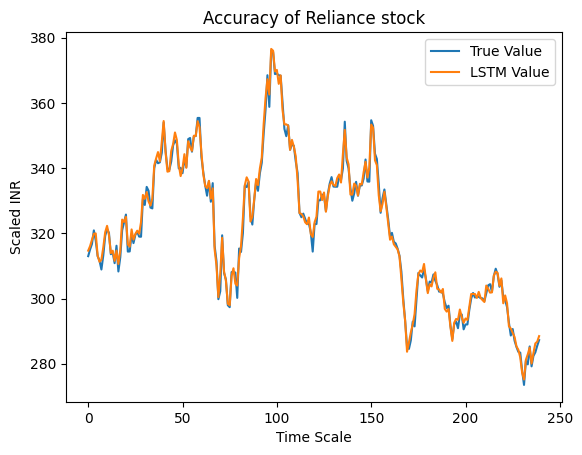

correctly predicted values in percentage range of  1 are:  224
Incorrectly predicted values in percentage range of  1 are:  16
correctly predicted values in percentage range of  2 are:  240
Incorrectly predicted values in percentage range of  2 are:  0
correctly predicted values in percentage range of  3 are:  240
Incorrectly predicted values in percentage range of  3 are:  0
correctly predicted values in percentage range of  4 are:  240
Incorrectly predicted values in percentage range of  4 are:  0
correctly predicted values in percentage range of  5 are:  240
Incorrectly predicted values in percentage range of  5 are:  0
correctly predicted values in percentage range of  6 are:  240
Incorrectly predicted values in percentage range of  6 are:  0
correctly predicted values in percentage range of  7 are:  240
Incorrectly predicted values in percentage range of  7 are:  0
correctly predicted values in percentage range of  8 are:  240
Incorrectly predicted values in percentage range of  8

In [ ]:
y_pred = y_pred.flatten()

plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title("Accuracy of Reliance stock")
plt.xlabel('Time Scale')
plt.ylabel('Scaled INR')
plt.legend()
plt.show()

diff = y_pred - y_test
var = ((abs(diff))/y_test)*100

not_corr = [0,0,0,0,0,0,0,0,0,0]
corr = [0,0,0,0,0,0,0,0,0,0]
for i in range(0,10):
  for value in var :
    if value <= (i+1):
      corr[i] = corr[i]+1
    else:
      not_corr[i] = not_corr[i]+1
for i in range(0,10):
  print("correctly predicted values in percentage range of ",i+1,"are: ",corr[i])
  print("Incorrectly predicted values in percentage range of ",i+1,"are: ",not_corr[i])
accuracy = [0,0,0,0,0,0,0,0,0,0]
for i in range(0,10):
  accuracy[i] = (corr[i]/(corr[i] + not_corr[i]))*100
  print("The accuracy of LSTM model in percentage range of ",i+1,"is :",accuracy[i])
# y_pred=y_pred.flatten()
# X_test=y_.flatten()
mse = metrics.mean_squared_error(y_test,y_pred)
mae = metrics.mean_absolute_error(y_test,y_pred)
print(mse)
print(mae)
